In [2]:
# Dependancies
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import time
import pandas as pd
from scipy import stats

c:\Users\billo\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\billo\miniconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\billo\miniconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Define the model

In our implementations, 
- $n$ is the number of observations $y = (y_1, ..., y_n)$. $y_i | \theta_i \sim F(\theta) = N(\theta, \tau)$ where $\tau$ is fixed. The prior on the $\theta_i$ is of the form $G_0 = N(0,1)$. 
- $c = (c_1, ..., c_n)$ is a list of integers, where $c_i$ is the cluster of observation $i$
- $\phi$ or $\theta$ depending of the algorithms is a list where $\phi_i$ is the mean of the cluster $c_i$


We initialize with each observation belonging to one cluster with mean equal to the value of the observation except for algorithm 4 and 5 where we initialize all observations in one cluster with $\theta$ equal to the empirical mean of the observations


### Dataset

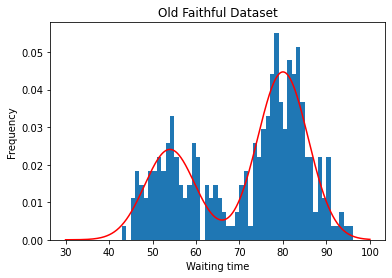

In [3]:
faithful_df = pd.read_csv("faithful.csv")
del faithful_df["Unnamed: 0"]
faithful_data = np.array(faithful_df["waiting"])

def prior_distribution(x, mean1=54, mean2=80, var=5.8, mixture=0.35):
    return mixture * stats.norm.pdf(x, mean1, var) + (1 - mixture) * stats.norm.pdf(x, mean2, var)

# Hand-picked parameters
x = np.linspace(30, 100, 1000)
plt.plot(x, prior_distribution(x), color='red')


# Plot the histogram of the old faithful dataset
plt.hist(faithful_data, bins=range(min(faithful_data), max(faithful_data) + 1), density=True)

plt.xlabel('Waiting time')
plt.ylabel('Frequency')
plt.title('Old Faithful Dataset')
plt.show()


###
faithful_data = faithful_data.astype(float)

In [4]:
np.var(faithful_data)

184.14381487889273

This dataset contains the waiting time between the eruptions of the Old Faithful geyser in Yellowstone National Park, Wyoming, USA.
We observe that the observations seems to come from a mixture of two Gaussians. We will try to infer the means of each of those Gaussians as well which cluster each observation belongs to. Regarding the variance, we hand tested different parameters and $\tau = 5.8$ for both Gaussian seems to be a great fit. 

As we changed our data, we must ajust the following parameters :
- xx
- xx

### General Case

In [5]:
tau = 5.8
alpha = 0.5

In [6]:
# G0 is a normal distribution
def g0_sampler():
    return np.random.normal(np.mean(faithful_data), np.var(faithful_data))

# f is a normal distribution with mean theta and variance tau
def f_sampler(theta):
    return np.random.normal(theta, tau)

# F(x, theta) evaluates F (normal distribution) in x
def F_likelihood(theta, x):
    return np.exp(-(theta - x)**2 / (2 * tau**2))

def F_loglikelihood(theta, x):
    return -(theta - x)**2 / (2 * tau**2)

In [7]:
def g0_logdensity(theta):
    return -theta**2 / 2 - np.log(np.sqrt(2 * np.pi))

Assume $x_i \mid \mu \sim \mathcal{N}\left(\mu = \theta, \sigma^2 = \tau\right)$ i.i.d.and $\mu \sim \mathcal{N}\left(\mu_0 = 0, \sigma_0^2 = 1\right)$. Then:
$$
\mu \mid x_{c1}, x_{c2}, \cdots, x_{ck} \sim \mathcal{N}\left(\frac{\sigma_0^2}{\frac{\sigma^2}{n}+\sigma_0^2} \overline{x_c}+\frac{\sigma^2}{\frac{\sigma^2}{n}+\sigma_0^2} \mu_0,\left(\frac{1}{\sigma_0^2}+\frac{n}{\sigma^2}\right)^{-1}\right)
$$

In [8]:
def posterior(y):
    mean = np.mean(y)
    number = len(y)
    return np.random.normal((1+ tau/number)*mean, 1/(1+ number/tau))

### Dirichlet process

In [9]:
def DP_loglikelihood(thetas):
    lh = 0
    for i, theta in enumerate(thetas):
        if theta in thetas[:i]:
            lh += np.log(np.sum(thetas[:i] == theta) / (i + alpha))
        else:
            lh += np.log(alpha / (i + alpha)) + g0_logdensity(theta)
    return lh

### Auxilary functions

In [10]:
def find_unused_cluster(c):
    # Find the first unused cluster
    for k in range(len(c)):
        if np.sum(c == k) == 0:
            return k

    raise Exception("No unused cluster found")

def update_cluster_phis(c, phi, lh, y):
    for c_unique in np.unique(c):
        phi[c_unique] = np.mean(y[c == c_unique])
        lh[c == c_unique] = F_loglikelihood(phi[c_unique], y[c == c_unique])


In [11]:
# Compute autocorrelation of a multivariate time series
def autocorr(x):
    ac = np.zeros_like(x)
    x_centered = x - np.mean(x, axis=0)
    for i in range(x.shape[1]):
        ac[:, i] = np.correlate(x_centered[:, i], x_centered[:, i], mode='full')[x.shape[0]-1:]
    return ac

#### Auxilary functions for the conjugate prior case (Algorithms 1, 2, 3)

In [12]:
def Hi_sampler(y):
    m = (y / tau**2) / (1 / tau**2 + 1 / 1**2)
    s = 1 / (1 / tau**2 + 1 / 1**2)
    return np.random.normal(m, s)

def ri_integral(y):
    return tau * np.exp(-y**2 / (2 + 2 * tau**2)) / np.sqrt(tau**2 + 1)

### Util functions to run Run algorithms

In [13]:
def to_cs_phis(thetas):
    phis = np.zeros_like(thetas, dtype=float)
    cs = np.zeros_like(thetas, dtype=int)
    for i, theta in enumerate(thetas):
        for c_unique, theta_unique in enumerate(np.unique(theta)):
            cs[i, theta == theta_unique] = c_unique
            phis[i, c_unique] = theta_unique
    return cs, phis

In [27]:
def run_algorithm(algorithm, N, y):
    """
    Run algorithm N times (n_iter) and plot evolution of log_likelyhood, theta and cluster assignments
    """
    # Run algorithm
    n = len(y)
    start_time =  time.time()
    cs, phis = algorithm(N, y)
    end_time = time.time()

    print(f"Time per interation: {(end_time - start_time) / N:.6f} seconds")

    complete_llhs = np.zeros((N+1), dtype=float)
    for i in range(N+1):
        complete_llhs[i] = F_loglikelihood(phis[i, cs[i]], y).sum() + DP_loglikelihood(phis[i, cs[i]])

    # Compute autocorrelation time of number of distinct clusters
    ks = np.zeros((N+1), dtype=int)
    for i in range(N+1):
        ks[i] = len(np.unique(cs[i]))

    ac = autocorr(ks.reshape(-1, 1))
    ac = ac / ac[0]
    # ac_time_limit is the first time the autocorrelation is below 0.05
    ac_time_limit = np.argmax(ac < 0.05)
    ac_time = 1 + 2 * np.sum(ac[:ac_time_limit])
    print(f"Autocorrelation time: {ac_time:.2f}")


    # define infinite list of colors
    COLORS = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    for i, cluster in enumerate(np.unique(cs[-1])):
        if np.sum(cs[-1] == cluster) == 1:
            plt.scatter(np.arange(n)[cs[-1] == cluster], y[cs[-1] == cluster], color="black")
        else:
            color = next(COLORS)
            plt.scatter(np.arange(n)[cs[-1] == cluster], y[cs[-1] == cluster], label=i, color=color)
            plt.axhline(phis[-1, cluster], color=color, linestyle="--")
    plt.title("Generated data")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

    # Plot evolution of log likelihood
    plt.figure()
    plt.plot(np.arange(N+1), complete_llhs)
    plt.title("Log likelihood")
    plt.xlabel("Iteration")
    plt.ylabel("Log likelihood")
    plt.show()

    # plot evolution of theta
    plt.figure()
    it_list = []
    phi_list = []
    size_list = []
    for it in range(0, N+1):
        phis_counts = np.unique(phis[it, cs[it]], return_counts=True)
        phi_list.extend(phis_counts[0])
        it_list.extend([it] * len(phis_counts[0]))
        size_list.extend(phis_counts[1])

    plt.scatter(it_list, phi_list, s= 100 * np.square(np.array(size_list, dtype=float) / np.max(size_list)), c=size_list)
    plt.title("Cluster assignments")
    plt.xlabel("Iteration")
    plt.ylabel("Cluster mean")
    plt.colorbar()
    plt.show()


    plt.plot(ac)
    plt.title("Autocorrelation of number of clusters")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    # Plot ac_time_limit
    plt.axvline(ac_time_limit, color="red", linestyle="--")
    plt.show()


In [48]:
def run_algorithm_multiple(algorithm, N, R, y):
    """
    Run algorithm N times (n_iter) and plot evolution of log_likelyhood, theta and cluster assignments
    """
    # Run algorithm
    y = len(y)
    cs_list = []
    phis_list = []
    y_list = [y for _ in range(R)]
    start_time =  time.time()
    for y in y_list:
        cs, phis = algorithm(N, y)
        cs_list.append(cs)
        phis_list.append(phis)
    end_time = time.time()

    print(f"Total time: {(end_time - start_time):.6f} seconds")
    print(f"Time per interation: {(end_time - start_time) / (R*N):.6f} seconds")

    complete_llhs = np.zeros((R, N+1), dtype=float)
    for r in range(R):
        for i in range(N+1):
            complete_llhs[r, i] = F_loglikelihood(phis_list[r][i, cs_list[r][i]], y_list[r]).sum() + DP_loglikelihood(phis_list[r][i, cs_list[r][i]])

    # ------------------------------ #
    # Final log likelihood and best log likelihood

    final_llhs = [llh[-1] for llh in complete_llhs]
    best_llhs = [np.max(llh) for llh in complete_llhs]

    print(f"Final log likelihood : mean : {np.mean(final_llhs):.2f}, std : {np.std(final_llhs):.2f}")
    print(f"Best log likelihood : mean : {np.mean(best_llhs):.2f}, std : {np.std(best_llhs):.2f}")


    # ------------------------------ #
    # Autocorrelation time - number of clusters

    # Compute autocorrelation time of number of distinct clusters
    ks = np.zeros((R, N+1), dtype=int)
    for r in range(R):
        for i in range(N+1):
            ks[r, i] = len(np.unique(cs_list[r][i]))

    ac = autocorr(ks.T) 
    print(ac.shape)
    ac = ac / ac[0]
    # ac_time_limit is the first time the autocorrelation is below 0.05
    ac_time_limit = np.argmax(ac < 0.05, axis=0)
    ac_times = []
    for r in range(R):
        ac_times.append(1 + 2 * np.sum(ac[1:ac_time_limit[r], r]))
    print(f"ACT n clusters : mean : {np.mean(ac_times):.2f}, std : {np.std(ac_times):.2f}")

    # ------------------------------ #
    # Autocorrelation time - phi[c]

    ac = autocorr(np.concatenate([np.array([
        phis_list[r][i, cs_list[r][i]]
        for i in range(N+1)
    ]).T for r in range(R)]).T)
    print(ac.shape)
    ac = ac / ac[0]
    # ac_time_limit is the first time the autocorrelation is below 0.05
    ac_time_limit = np.argmax(ac < 0.05, axis=0)
    ac_times = []
    for r in range(R):
        ac_time_avg = []
        for i in range(n):
            ac_time_avg.append(1 + 2 * np.sum(ac[1:ac_time_limit[r*n + i], r*n + i]))
        ac_times.append(np.mean(ac_time_avg))

    print(f"ACT thetas : mean : {np.mean(ac_times):.2f}, std : {np.std(ac_times):.2f}")

    # ------------------------------ #
    # Clusters

    

    print("-----------------------------")


# Algorithms

### Algorithm 1

In [24]:
def algorithm_1(N, y):
    # Initialize
    n = len(y)
    thetas = np.zeros((N+1, n), dtype=float)
    thetas[0] = y.copy()

    # Loop over data
    for i in range(1, N+1):
        theta = thetas[i-1].copy()

        # Perform Gibbs sampling
        for j in range(n):
            lh_proposals = np.zeros(n, dtype=float)
            for theta_unique in np.unique(theta):
                lh_proposals[theta == theta_unique] = F_likelihood(theta_unique, y[j])
            lh_proposals[j] = alpha * ri_integral(y[j])

            # Sample j
            j_proposal = np.random.choice(n, p=lh_proposals / np.sum(lh_proposals))
            if j_proposal == j:
                theta[j] = Hi_sampler(y[j])
            else:
                theta[j] = theta[j_proposal]

        thetas[i] = theta

    return thetas

## Algorithm 2

In [28]:
def algorithm_2(n_iters, y, alpha):
    n = len(y)
    phis = np.zeros((n_iters+1, n), dtype=float)
    cs = np.zeros((n_iters+1, n), dtype=int)
    cs[0] = np.arange(n)
    phis[0] = y.copy()

    for iter in range(1, n_iters+1):
        phi = phis[iter-1].copy() 
        c = cs[iter-1].copy()

        for ii in range(n):
            c_unique, c_count = np.unique(c, return_counts=True)
            # get n_-i,c
            c_count -= (c_unique == c[ii]).astype(int)

            
            # Remove phi_ci from the state and draw a new value for ci from eq 3.6
            new_parameter_prob = alpha / (n - 1 + alpha) * ri_integral(y[ii])
            old_parameter_prob = 1 / (n - 1 + alpha) * F_likelihood(phi[c_unique], y[ii])
            # Sampling probabilities for all [old params , new param] 
            sampling_prob = np.append(old_parameter_prob * c_count , new_parameter_prob)
            # Normalize to get a probability distribution
            sampling_prob /= np.sum(sampling_prob)
            # Choose cluster with probability sampling_prob
            # The new cluster replaces an unused cluster
            if np.sum(c == c[ii]) == 1:
                ci_star = np.random.choice(np.append(c_unique, c[ii]), p=sampling_prob)
            else:
                ci_star = np.random.choice(np.append(c_unique, find_unused_cluster(c)), p=sampling_prob)
            c[ii] = ci_star
            if np.sum(ci_star == c) == 1:
                phi[ci_star] = Hi_sampler(y[c == ci_star])
            
        
        for c_unique in np.unique(c):
            phi[c_unique] = posterior(y[c == c_unique])
    
        cs[iter] = c.copy()
        phis[iter] = phi.copy()

    return cs, phis


Time per interation: 0.039514 seconds
Autocorrelation time: 3.63


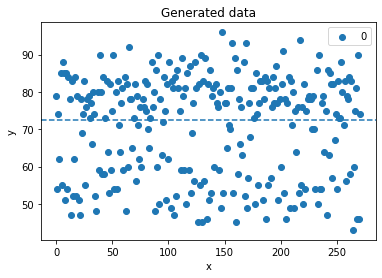

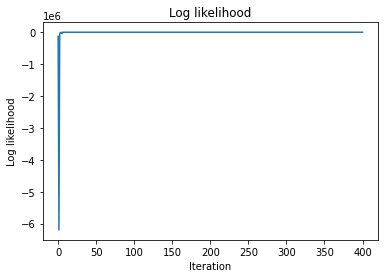

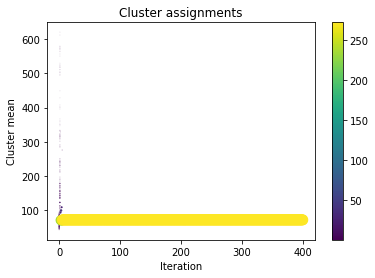

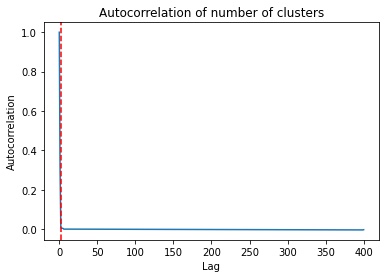

In [29]:
run_algorithm(lambda N, y: algorithm_2(N, y, alpha), 400, faithful_data)

## Algorithm 4

In [30]:
def algorithm_4(N, y):
    n = len(y)
    cs = np.zeros((N+1, n), dtype=int)
    phis = np.zeros((N+1, n), dtype=float)
    lhs = np.zeros((N+1, n), dtype=float)
    lhs[0] = np.array([F_likelihood(phis[0, j], y[j]) for j in range(len(y))])
    # Initialization exception : all points are in the same cluster of mean = empirical_mean(y)

    phis[0] = np.full(n,np.mean(y))

    for i in range(1, N+1):
        c = cs[i-1].copy()
        phi = phis[i-1].copy()
        lh = lhs[i-1].copy()

        for j in range(n):
            k = len(np.unique(c[np.arange(n) != j]))
            c_proposal = find_unused_cluster(c)

            if np.sum(c == c[j]) == 1:
                if np.random.uniform() < 1 / (k + 1):
                    c[j] = c_proposal
                    phi[c[j]] = g0_sampler()
            
            else:
                phi_proposal = g0_sampler()
                lh_proposals = np.zeros(n)
                for c_unique in np.unique(c):
                    lh_proposals[c == c_unique] = F_likelihood(phi[c_unique], y[j])

                lh_proposals[j] = (alpha / (k + 1)) * F_likelihood(phi_proposal, y[j]) 

                j_proposal = np.random.choice(n, p=lh_proposals / np.sum(lh_proposals))

                if j_proposal == j:
                    c[j] = c_proposal
                    phi[c[j]] = phi_proposal
                    lh[j] = lh_proposals[j_proposal] * ((k + 1) / alpha)
                else:
                    c[j] = c[j_proposal]
                    lh[j] = lh_proposals[j_proposal]

        update_cluster_phis(c, phi, lh, y)
            
        cs[i] = c
        phis[i] = phi
        lhs[i] = lh

    return cs, phis

Time per interation: 0.067375 seconds
Autocorrelation time: 15.38


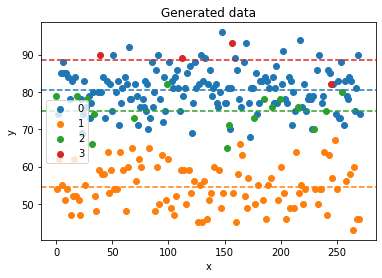

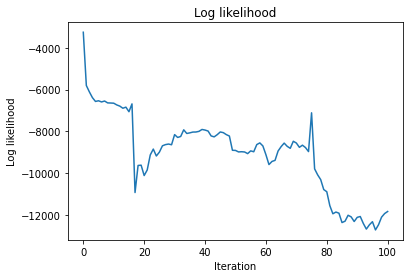

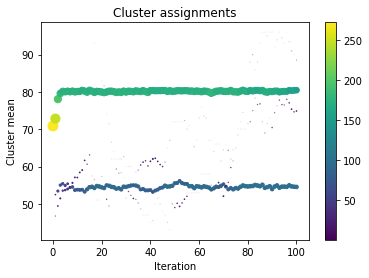

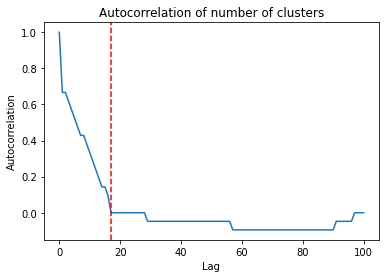

In [31]:
run_algorithm(lambda N, y: algorithm_4(N, y), 100, faithful_data)

## Algorithm 5

In [32]:
def algorithm_5_sampler(alpha, c_unique, c_count, c, n):
        # Draw a candidate phi_i_star from Eq 5.4
        new_parameter_prob = alpha / (n - 1 + alpha)
        old_parameter_prob = 1 / (n - 1 + alpha)
        # Sampling probabilities for all [old params , new param] and normalize to get a probability distribution
        sampling_prob = np.append(old_parameter_prob * c_count , new_parameter_prob)
        sampling_prob /= np.sum(sampling_prob)
        # Choose cluster with probability sampling_prob
        # The new cluster replaces an unused cluster
        ci_star = np.random.choice(np.append(c_unique, find_unused_cluster(c)), p=sampling_prob)
        return ci_star

def algorithm_5(n_iters, y, alpha):
    n = len(y)
    cs = np.zeros((n_iters+1, n), dtype=int)
    phis = np.zeros((n_iters+1, n), dtype=float)
    lhs = np.zeros((n_iters+1, n), dtype=float)
    # Initialization exception : all points are in the same cluster of mean = empirical_mean(y)
    phis[0] = np.full(n,np.mean(y))


    for iter in range(1,n_iters+1):
        c = cs[iter-1].copy()
        phi = phis[iter-1].copy()
        lh = lhs[iter-1].copy()

        for ii in range(n):
            c_unique, c_count = np.unique(c, return_counts=True)
            # get n_-i,c
            c_count -= (c_unique == c[ii]).astype(int)
            # Sample a ci_star from Eq 5.4
            ci_star = algorithm_5_sampler(alpha, c_unique, c_count, c, n)

            # If the sampled index is the last one, we sample from G0
            if ci_star == len(c_unique):
                phi_proposal = g0_sampler()
            else: # Else we use an existing cluster
                phi_proposal = phi[ci_star]
            
            lh_proposal = F_likelihood(phi_proposal, y[ii])

            # Compute acceptance probability
            acceptance_prob = min(1, lh_proposal / lh[ii])

            # Accept or reject
            if np.random.rand() < acceptance_prob:
                c[ii] = ci_star
                phi[c[ii]] = phi_proposal
                lh[ii] = lh_proposal
        


        for c_unique in np.unique(c):
            phi[c_unique] = np.mean(y[c == c_unique])

        cs[iter] = c.copy()
        phis[iter] = phi.copy()
        lhs[iter] = lh.copy()

    return cs, phis

C:\Users\billo\AppData\Local\Temp\ipykernel_15412\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.031594 seconds
Autocorrelation time: 84.75


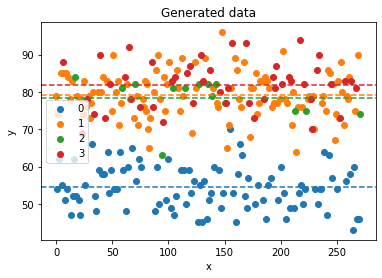

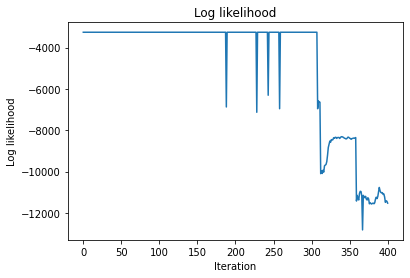

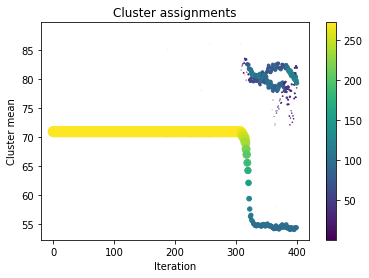

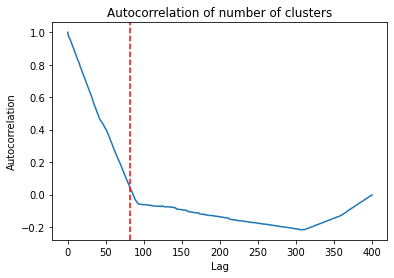

In [33]:
run_algorithm(lambda N, y: algorithm_5(N, y, alpha), 400, faithful_data)

## Algorithm 6

In [34]:
def algorithm_6_sample(theta):
    # Choose wether we sample from existing theta or from g0
    if np.random.rand() < alpha / (len(theta) + alpha):
        # Sample from g0
        theta = g0_sampler()
    else:
        # Sample from existing theta
        theta = np.random.choice(theta)

    return theta

def algorithm_6(N, y):
    n = len(y)
    thetas = np.zeros((N+1, n))
    lhs = np.zeros((N+1, n))
    lhs[0] = np.array([F_likelihood(thetas[0, j], y[j]) for j in range(n)])
    thetas[0] = y.copy()

    for i in range(1, N+1):
        theta = thetas[i-1].copy()
        lh = lhs[i-1].copy()
        for j in range(n):
            theta_proposal = algorithm_6_sample(theta[np.arange(n) != j])
            lh_proposal = F_likelihood(theta_proposal, y[j])

            # Compute acceptance probability
            a = min(1, lh_proposal / lh[j])

            # Accept or reject
            if np.random.rand() < a:
                theta[j] = theta_proposal
                lh[j] = lh_proposal
            
        thetas[i] = theta
        lhs[i] = lh

    return thetas


Time per interation: 0.008858 seconds
Autocorrelation time: 54.79


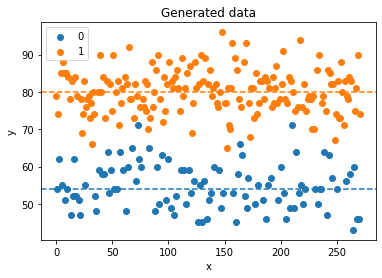

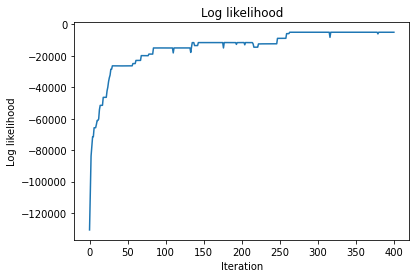

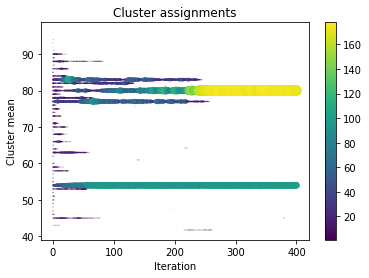

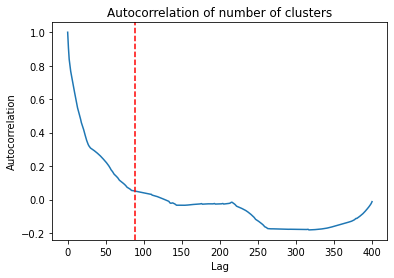

In [35]:
run_algorithm(lambda N, y: to_cs_phis(algorithm_6(N, y)), 400, faithful_data)

## Algorithm 7

In [36]:
def algorithm_7(N, y):
    n = len(y)
    cs = np.zeros((N+1, n), dtype=int)
    phis = np.zeros((N+1, n), dtype=float)
    lhs = np.zeros((N+1, n), dtype=float)
    lhs[0] = np.array([F_likelihood(phis[0, j], y[j]) for j in range(len(y))])
    cs[0] = np.arange(n)
    phis[0] = y.copy()

    for i in range(1, N+1):
        c = cs[i-1].copy()
        phi = phis[i-1].copy()
        lh = lhs[i-1].copy()

        for j in range(n):
            # test if c[j] is a singleton
            if np.sum(c == c[j]) == 1:
                # Choose c[j] from c[-j] with probability n_i / (n - 1)
                c_proposal = np.random.choice(c[c != c[j]])
                lh_proposal = F_likelihood(phi[c_proposal], y[j])

                # Compute acceptance probability
                a = min(1, ((n-1) / alpha) * lh_proposal / lh[j])

                # Accept or reject
                if np.random.rand() < a:
                    c[j] = c_proposal
                    phi[c[j]] = phi[c_proposal]
                    lh[j] = lh_proposal

            else:
                c_proposal = find_unused_cluster(c)
                phi_proposal = g0_sampler()
                lh_proposal = F_likelihood(phi_proposal, y[j])

                # Compute acceptance probability
                a = min(1, (alpha / (n - 1)) * lh_proposal / lh[j])

                # Accept or reject
                if np.random.rand() < a:
                    c[j] = c_proposal
                    phi[c[j]] = phi_proposal
                    lh[j] = lh_proposal

        for j in range(n):
            # test if c[j] is not a singleton
            if np.sum(c == c[j]) > 1:

                # Compute transition probas
                lh_proposals = np.zeros(n, dtype=float)
                for c_unique in np.unique(c):
                    lh_proposals[c == c_unique] = F_likelihood(phi[c_unique], y[j])
                lh_proposals[j] = 0

                j_proposal = np.random.choice(n, p=lh_proposals / np.sum(lh_proposals))
                c[j] = c[j_proposal]
                lh[j] = lh_proposals[j_proposal]

        update_cluster_phis(c, phi, lh, y)  

        cs[i] = c
        phis[i] = phi
        lhs[i] = lh

    return cs, phis

C:\Users\billo\AppData\Local\Temp\ipykernel_15412\2043883878.py:37: RuntimeWarning: divide by zero encountered in scalar divide
  a = min(1, (alpha / (n - 1)) * lh_proposal / lh[j])
C:\Users\billo\AppData\Local\Temp\ipykernel_15412\2043883878.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  a = min(1, ((n-1) / alpha) * lh_proposal / lh[j])
C:\Users\billo\AppData\Local\Temp\ipykernel_15412\2043883878.py:37: RuntimeWarning: invalid value encountered in scalar divide
  a = min(1, (alpha / (n - 1)) * lh_proposal / lh[j])
C:\Users\billo\AppData\Local\Temp\ipykernel_15412\2043883878.py:23: RuntimeWarning: invalid value encountered in scalar divide
  a = min(1, ((n-1) / alpha) * lh_proposal / lh[j])


Time per interation: 0.254396 seconds
Autocorrelation time: 29.81


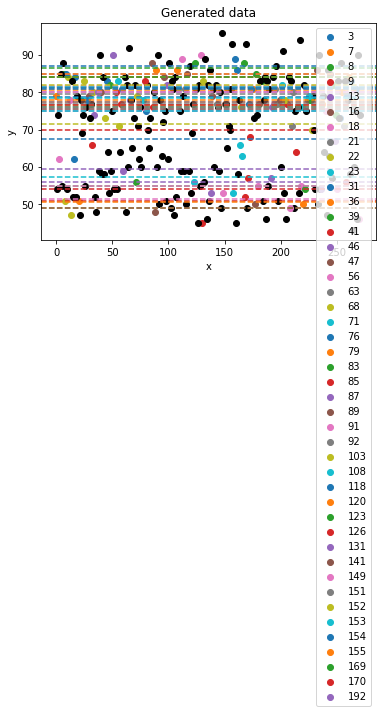

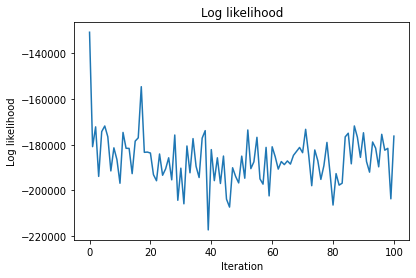

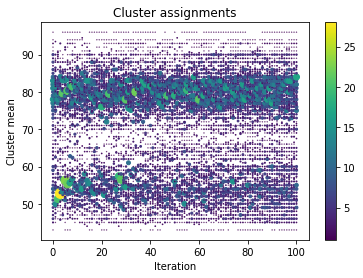

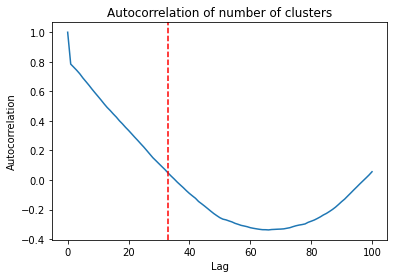

In [37]:
run_algorithm(lambda N, y: algorithm_7(N, y), 100, faithful_data)

## Algorithm 8

In [38]:
def algorithm_8(y, N, m):
    n = len(y)
    phi_table = np.zeros((N+1, n + m), dtype=float)
    c_table = np.zeros((N+1, n), dtype=int)
    c_table[0] = np.array([i + 1 for i in range(n)])
    phi_table[0, :n] = y.copy()
    c_table[0] = np.arange(n) 

    for loop in range(N):
        c = c_table[loop].copy()
        phi = phi_table[loop].copy()
        for i in range(n):
            c_minus_i = np.concatenate((c[:i], c[i + 1:]))
            k_ = np.unique(c_minus_i).size
            if c[i] in c_minus_i:
                phi[-m:] = np.array([g0_sampler() for _ in range(m)])
            else:
                phi[-m + 1:] = np.array([g0_sampler() for _ in range(m - 1)])
            probabilities = []
            for cluster in range(1, n + m + 1):
                if cluster <= n:
                    n_occurence = np.sum(c_minus_i == cluster)
                    probabilities.append(n_occurence / (n - 1 + alpha) * F_likelihood(phi[cluster - 1], y[i]))
                else:
                    probabilities.append((alpha / m) / (n - 1 + alpha) * F_likelihood(phi[cluster - 1], y[i])) 
            probabilities = np.array(probabilities)
            probabilities_without_nan = np.nan_to_num(probabilities, nan=0)
            sum_prob_without_nan = np.sum(probabilities_without_nan)
            if sum_prob_without_nan == 0:
                c[i] = np.random.choice(np.array([i + 1 for i in range(n + m)]))
            else:
                probabilities /= sum_prob_without_nan
                c[i] = np.random.choice(np.array([i + 1 for i in range(n + m)]), p=probabilities)
        for cluster in np.unique(c):
            phi[cluster - 1] = np.mean(y[c == cluster])
        phi_table[loop + 1] = phi
        c_table[loop + 1] = c

    return c_table - 1, phi_table

Time per interation: 1.104170 seconds
Autocorrelation time: 6.08


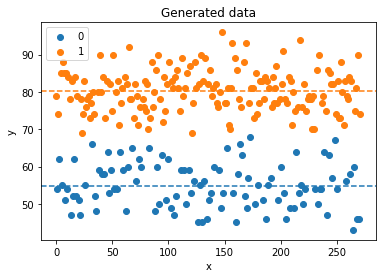

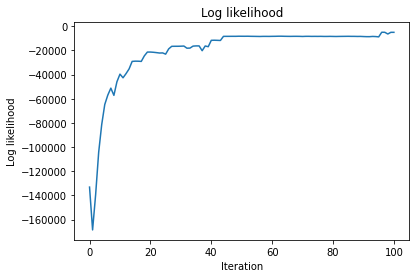

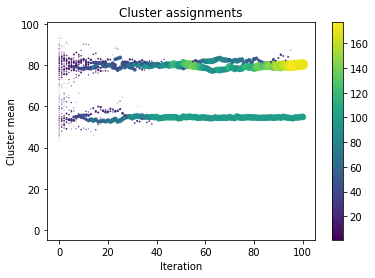

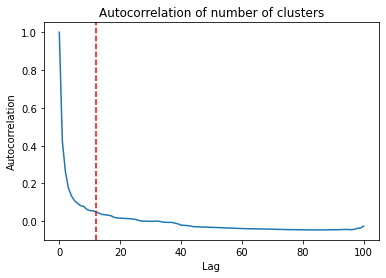

In [39]:
run_algorithm(lambda N, y: algorithm_8(y, N, 10), 100, faithful_data)

In [54]:
print("Algorithm 1")
run_algorithm_multiple(lambda N, y: to_cs_phis(algorithm_1(N, y)), 100, 10)
print("Algorithm 2")
run_algorithm_multiple(lambda N, y: algorithm_2(N, y, alpha), 100, 10)
print("Algorithm 4")
run_algorithm_multiple(lambda N, y: algorithm_4(N, y), 100, 10)
print("Algorithm 5")
run_algorithm_multiple(lambda N, y: algorithm_5(N, y, alpha), 100, 10)
print("Algorithm 6")
run_algorithm_multiple(lambda N, y: to_cs_phis(algorithm_6(N, y)), 100, 10)
print("Algorithm 7")
run_algorithm_multiple(lambda N, y: algorithm_7(N, y), 100, 10)
print("Algorithm 8")
run_algorithm_multiple(lambda N, y: algorithm_8(y, N, 10), 100, 10)

Algorithm 1


### Choosing Alpha

In [43]:
alphas = [0.1, 0.2, 0.5, 0.6, 0.8, 1, 2]

In [47]:
for alpha in alphas:
    print(f"alpha = {alpha}")
    run_algorithm_multiple(lambda N, y: algorithm_5(N, y, alpha), 400, R=10 ,y=faithful_data)
    print("-----------------------------")

C:\Users\billo\AppData\Local\Temp\ipykernel_15412\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


alpha = 0.1
Total time: 139.098871 seconds
Time per interation: 0.034775 seconds
Final log likelihood : mean : -5009.24, std : 1103.86
Best log likelihood : mean : -3259.18, std : 0.00
(401, 10)
ACT n clusters : mean : 63.84, std : 49.86


C:\Users\billo\AppData\Local\Temp\ipykernel_15412\3013186092.py:45: RuntimeWarning: invalid value encountered in divide
  ac = ac / ac[0]


(401, 2720)


NameError: name 'n' is not defined